# Apply spaTrack to infer a trajectory on spatial transcriptomic data from multiple time slices of axolotl brain regeneration.



Apply spaTrack to infer a trajectory on spatial transcriptomic data from multiple time slices of axolotl brain regeneration

This notebook presents an example of how spaTrack infer complete trajectories of axolotl telencephalon regeneration from integrating  multiple sample ST data.The spatial transcriptomic data for multiple time slices of axolotl brain regeneration can be downloaded from our [example data](http://116.6.21.110:8090/share/3ca60300-e8bd-4d67-8b68-14267e428523).

In [1]:
import warnings
warnings.filterwarnings("ignore")

import stereo as st
from stereo.core.ms_data import MSData
from stereo.core.ms_pipeline import slice_generator

## Load data

In this data, the cell type information is stored in `data.cells['cluster']` or `data.adata.obs['cluster']` and the spatial coordinates is stored by key **'X_spatial'**, this data also contains UMAP coordinates after running harmony.

In [2]:
data_path = '../../data/03.multiple.ST.slices.axolotl.brain/03.multiple.ST.slices.axolotl.brain.h5ad'

data = st.io.read_h5ad(data_path, spatial_key='X_spatial')

data

AnnData object with n_obs × n_vars = 2880 × 31146
    obs: 'cluster', 'Time'
    uns: 'sn'
    obsm: 'X_spatial', 'X_umap'

We utilized spatial coordinates and UMAP coordinates to visualize the tracking results at each time point after integrating multiple ST slides while removing potential batch effects. 

Additionally, we inferred the trajectory of the salamanders across the ST slides at each time point by leveraging the spatial coordinate information.

To visualize the trajectory on multiple ST slides, we plotted the inferred trajectory on the UMAP of the integrated data. 

Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

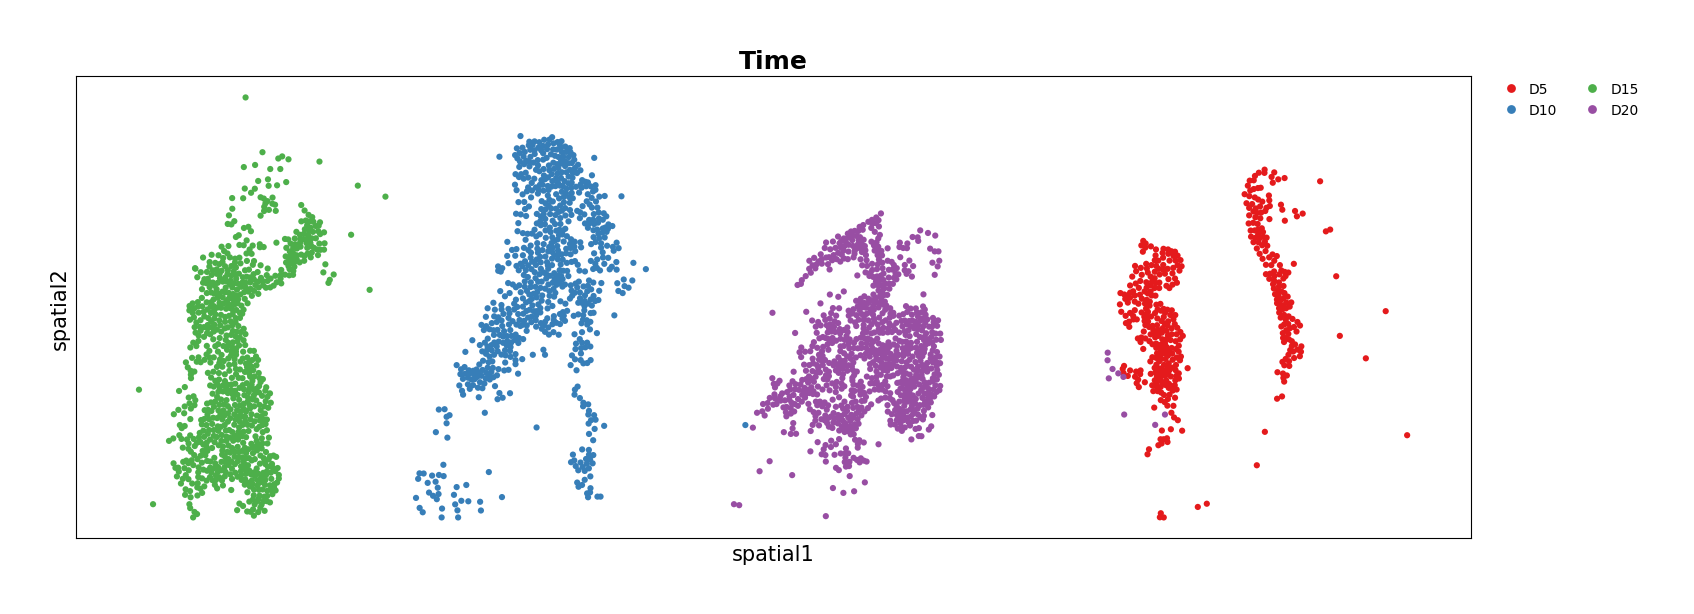

In [3]:
data.plt.cluster_scatter(res_key='Time', width=1800, height=600, marker='o', dot_size=20, show_plotting_scale=False, x_label='spatial1', y_label='spatial2', invert_y=False)

Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

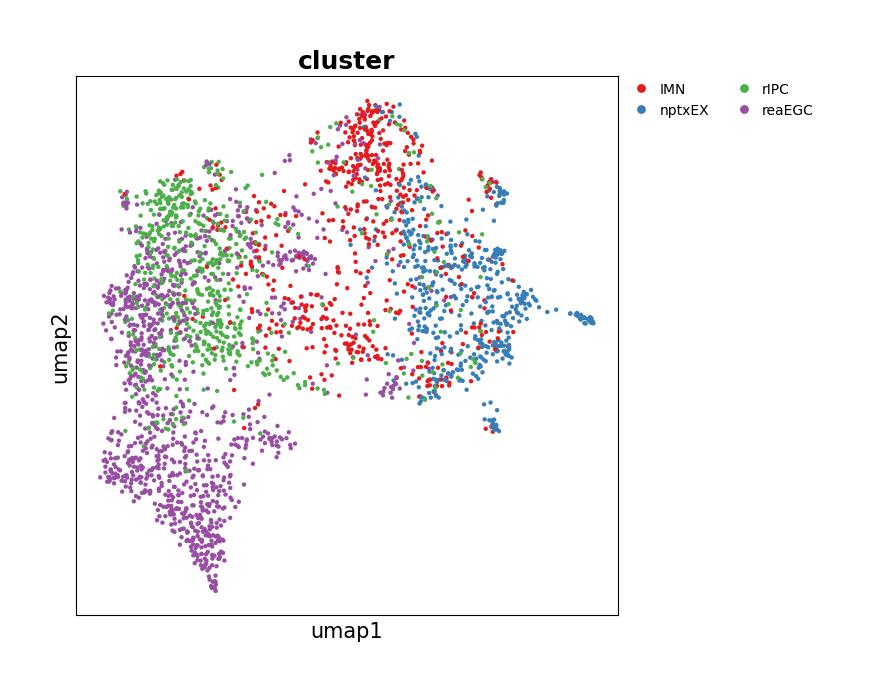

In [4]:
data.plt.umap(cluster_key='cluster', marker='o', dot_size=10, invert_y=False)

Distribution of cell types in the ST slides at each time point on physical space.

Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

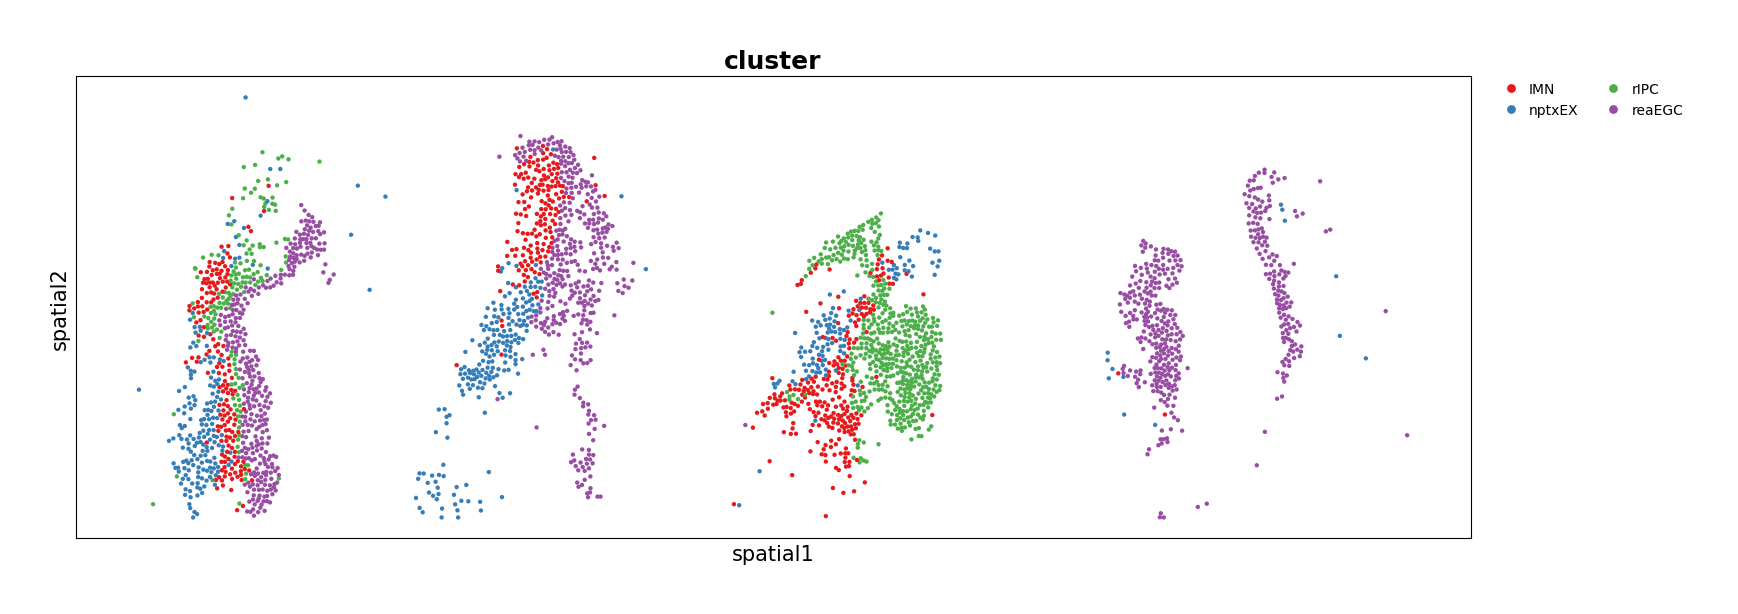

In [5]:
data.plt.cluster_scatter(
    res_key='cluster',
    width=1800, height=600,
    marker='o', dot_size=10,
    # palette=['#5254a3', '#8c6d31','#EEDC82','#d6616b'],
    x_label='spatial1', y_label='spatial2',
    show_plotting_scale=False,
    invert_y=False
)

## Calculate cell-transition probability

### Create a multi-sample data structure

Create a multi-sample data structure along the time points specified by obs-key **Time**, in this case, the data will be split into 4 single samples with 4 different **Time**.

In [6]:
ms_data = MSData.to_msdata(data, batch_key='Time')
ms_data

ms_data: {'D5': (435, 31146), 'D10': (738, 31146), 'D15': (820, 31146), 'D20': (887, 31146)}
num_slice: 4
names: ['D5', 'D10', 'D15', 'D20']
merged_data: None
obs: []
var: []
relationship: other
var_type: intersect to 0
current_mode: integrate
current_scope: scope_[0,1,2,3]
scopes_data: []
mss: []

We set the starting point of ST slides at each time point separately. Due to the disappearance of reaEGC at terminal time point D20, we used rIPC as the starting point based on the inferred trajectory in D15.
 
spaTrack implements an integrating framework to separately calculate cell-transition probability for each section and subsequently integrate all transition matrix to infer the complete trajectory. This scenario is suitable for multiple sections containing various cell types.

Next, we used UMAP embedding to calculate the cell velocity and plotted visualized trajectory lines.

In [7]:
time_and_start = {
    'D5': 'reaEGC',
    'D10': 'reaEGC',
    'D15': 'reaEGC',
    'D20': 'rIPC'
}
for time_point, start_cluster in time_and_start.items():
    print(time_point)
    subdata = ms_data[time_point]
    spt_st = subdata.tl.spa_track(cluster_res_key='cluster')
    spt_st.get_ot_matrix(data_type='spatial')
    spt_st.set_start_cells(select_way='cell_type', cell_type=start_cluster)
    spt_st.get_ptime()
    spt_st.get_velocity(spatial_key='umap', n_neigh_pos=80, n_neigh_gene=0)

D5


2024-11-05 15:06:17.603820: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[2024-11-05 15:06:19][Stereo][24427][MainThread][140515251496768][st_pipeline][77][INFO]: register algorithm spa_track to <stereo.core.st_pipeline.AnnBasedStPipeline object at 0x7fcbb35aa790>
[2024-11-05 15:06:19][Stereo][24427][MainThread][140515251496768][velocity][88][INFO]: Can not find PCA result, to calculate automatically using highly variable genes.
[2024-11-05 15:06:19][Stereo][24427][MainThread][140515251496768][velocity][89][INFO]: n_pcs: 50
[2024-11-05 15:06:19][Stereo][24427][MainThread][140515251496768][st_pipeline][41][INFO]: start to run pca...
[2024-11-05 15:06:23][Stereo][24427][MainThread][140515251496768][dim_reduce][99][INFO]: x_pca dType is changed from float64 to float32
[2024-11-05 15:06:23][Stereo][24427][MainThread][140515251496768][st_pipeline][44][INFO]: pca end, consume time 4.3459s.
[2024-11-05 15:06:23][Stereo][24427][MainThread][140

D10


[2024-11-05 15:06:32][Stereo][24427][MainThread][140515251496768][dim_reduce][99][INFO]: x_pca dType is changed from float64 to float32
[2024-11-05 15:06:32][Stereo][24427][MainThread][140515251496768][st_pipeline][44][INFO]: pca end, consume time 7.4595s.
[2024-11-05 15:06:32][Stereo][24427][MainThread][140515251496768][velocity][124][INFO]: alpha1(gene expression): 0.5   alpha2(spatial information): 0.5
[2024-11-05 15:06:36][Stereo][24427][MainThread][140515251496768][st_pipeline][77][INFO]: register algorithm spa_track to <stereo.core.st_pipeline.AnnBasedStPipeline object at 0x7fcbb3482a60>
[2024-11-05 15:06:36][Stereo][24427][MainThread][140515251496768][velocity][88][INFO]: Can not find PCA result, to calculate automatically using highly variable genes.
[2024-11-05 15:06:36][Stereo][24427][MainThread][140515251496768][velocity][89][INFO]: n_pcs: 50
[2024-11-05 15:06:36][Stereo][24427][MainThread][140515251496768][st_pipeline][41][INFO]: start to run pca...


D15


[2024-11-05 15:06:44][Stereo][24427][MainThread][140515251496768][dim_reduce][99][INFO]: x_pca dType is changed from float64 to float32
[2024-11-05 15:06:44][Stereo][24427][MainThread][140515251496768][st_pipeline][44][INFO]: pca end, consume time 8.8071s.
[2024-11-05 15:06:44][Stereo][24427][MainThread][140515251496768][velocity][124][INFO]: alpha1(gene expression): 0.5   alpha2(spatial information): 0.5
[2024-11-05 15:06:48][Stereo][24427][MainThread][140515251496768][st_pipeline][77][INFO]: register algorithm spa_track to <stereo.core.st_pipeline.AnnBasedStPipeline object at 0x7fcbb34870a0>
[2024-11-05 15:06:48][Stereo][24427][MainThread][140515251496768][velocity][88][INFO]: Can not find PCA result, to calculate automatically using highly variable genes.
[2024-11-05 15:06:48][Stereo][24427][MainThread][140515251496768][velocity][89][INFO]: n_pcs: 50
[2024-11-05 15:06:48][Stereo][24427][MainThread][140515251496768][st_pipeline][41][INFO]: start to run pca...


D20


[2024-11-05 15:06:59][Stereo][24427][MainThread][140515251496768][dim_reduce][99][INFO]: x_pca dType is changed from float64 to float32
[2024-11-05 15:06:59][Stereo][24427][MainThread][140515251496768][st_pipeline][44][INFO]: pca end, consume time 10.8131s.
[2024-11-05 15:06:59][Stereo][24427][MainThread][140515251496768][velocity][124][INFO]: alpha1(gene expression): 0.5   alpha2(spatial information): 0.5


## Visualize cell trajectory of multiple ST samples

Remerge all samples to one, the analysis results above will also be merged simultaneously, we will use this new integrated sample to run the following analysis.

In [8]:
ms_data.integrate()

AnnData object with n_obs × n_vars = 2880 × 31146
    obs: 'batch'
    uns: 'sn', 'spa_track', 'pca', 'pca_variance_ratio', 'key_record', 'P_grid', 'V_grid', 'bin_type', 'bin_size'
    obsm: 'X_spatial', 'X_umap', 'X_pca', 'velocity_umap'
    varm: 'PCs'

Transfer the cell type information from single samples to the integrated sample.

In [9]:
ms_data.to_integrate(scope=slice_generator[:], _from=slice_generator[:], res_key='cluster', item='cluster', type='obs')

Set the analysis scope and mode, the following analysis will run on the integrated sample which is merged from all samples.

In [10]:
ms_data.tl.set_scope_and_mode(scope=slice_generator[:], mode='integrate')

### Get An object of spaTrack

In [11]:
ms_spt = ms_data.tl.spa_track(cluster_res_key='cluster')

[2024-11-05 15:07:04][Stereo][24427][MainThread][140515251496768][ms_pipeline][113][INFO]: register algorithm spa_track to <class 'stereo.core.stereo_exp_data.AnnBasedStereoExpData'>-140512862937344


To calculate cell velocity, we only considered neighbor cells separately at each time point. 

After calculating cell velocity, we converted it to grid velocity for visualizing the trajectory. 

In [12]:
_1, _2 = ms_spt.get_velocity_grid(spatial_key='umap')

Visualization of trajectory on UMAP coordinates

Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

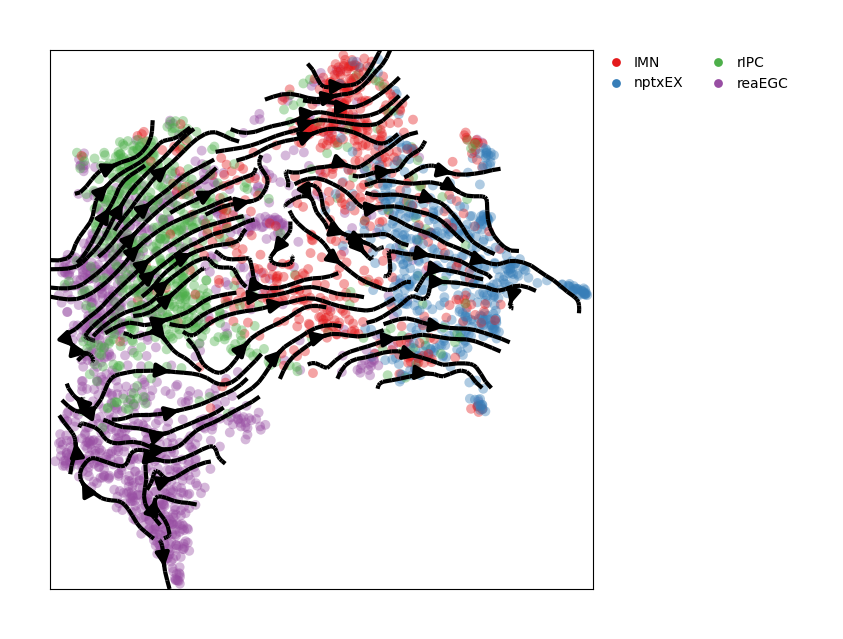

In [13]:
ms_spt.plot.stremplot(
    dot_size=50,
    stream_lines_density=2,
    stream_lines_width=3,
    stream_arrows_size=2,
    streamplot_kwargs=dict(minlength=0.2,maxlength=0.8),
    invert_y=False
)